In [1]:
import keras
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping
# %reload_ext mermaid
# import IPython
# IPython.load_ipython_extensions(["nb-mermaid/nb-mermaid"]);

Using TensorFlow backend.


In [2]:
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D,Reshape, Dropout, Dense, GlobalAveragePooling2D, \
BatchNormalization, Input, Flatten, MaxPooling2D, UpSampling2D,Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

In [3]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [4]:
csv_data = pd.read_csv('AND_Features.csv')

In [5]:
display(csv_data.head()), csv_data.shape

,Unnamed: 0,ImageId,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,0,0359a,2,1,1,0,2,2,0,2,2
1,1,0577a,2,1,1,0,2,2,0,1,2
2,2,1120a,2,1,1,3,2,2,0,2,2
3,3,1120b,1,1,1,0,2,2,0,2,2
4,4,1120c,2,1,1,0,2,2,0,0,2


(None, (1026, 11))

In [6]:
image_path = 'cleaned_AND_data_64x64/'
images = os.listdir(image_path)
len(images)

13850

In [7]:
images = pd.DataFrame(np.array(images), columns=['image'])
images.shape

(13850, 1)

In [8]:
csv_data[csv_data['ImageId']=='0344c']
list(images[images['image'].str.match('0344c')]['image'])

['0344c_num1.png', '0344cc_num1.png']

In [9]:
len(list(set(list(x[:4] for x in images['image'])))), len(list(set(list(x[:4] for x in csv_data['ImageId']))))

(1532, 462)

In [10]:
dataset_columns = csv_data.columns
display(csv_data.head(20))
csv_data.shape

,Unnamed: 0,ImageId,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,0,0359a,2,1,1,0,2,2,0,2,2
1,1,0577a,2,1,1,0,2,2,0,1,2
2,2,1120a,2,1,1,3,2,2,0,2,2
3,3,1120b,1,1,1,0,2,2,0,2,2
4,4,1120c,2,1,1,0,2,2,0,0,2
5,5,1121a,2,1,1,3,2,2,0,1,2
6,6,1121b,2,1,1,0,2,2,0,3,2
7,7,1121c,1,1,1,0,2,2,0,1,2
8,8,1229b,1,1,1,3,2,2,0,2,2
9,9,1302a,2,1,1,3,2,2,0,0,2


(1026, 11)

In [11]:
train_csv_data =  csv_data[:700]
val_csv_data =  csv_data[700:]
train_csv_data.shape, val_csv_data.shape

((700, 11), (326, 11))

In [12]:
f = []
for col in dataset_columns[2:]:
    f.append(csv_data[col].unique().shape[0])
f

[4, 5, 3, 5, 4, 4, 4, 5, 2]

In [13]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)
# encoded = GlobalAveragePooling2D()(x)

# encoder = Model(input_img, encoded)
# encoder.summary()
# print(encoded.shape)
# encoded = Flatten()(x)
# encoded = Dense(8*8*8)(encoded)
# # model = Model(input_img,encoded)
# # print(model.summary())
# # at this point the representation is (4, 4, 8) i.e. 128-dimensional
# r = Reshape(target_shape=(8,8,8))(encoded)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
__________

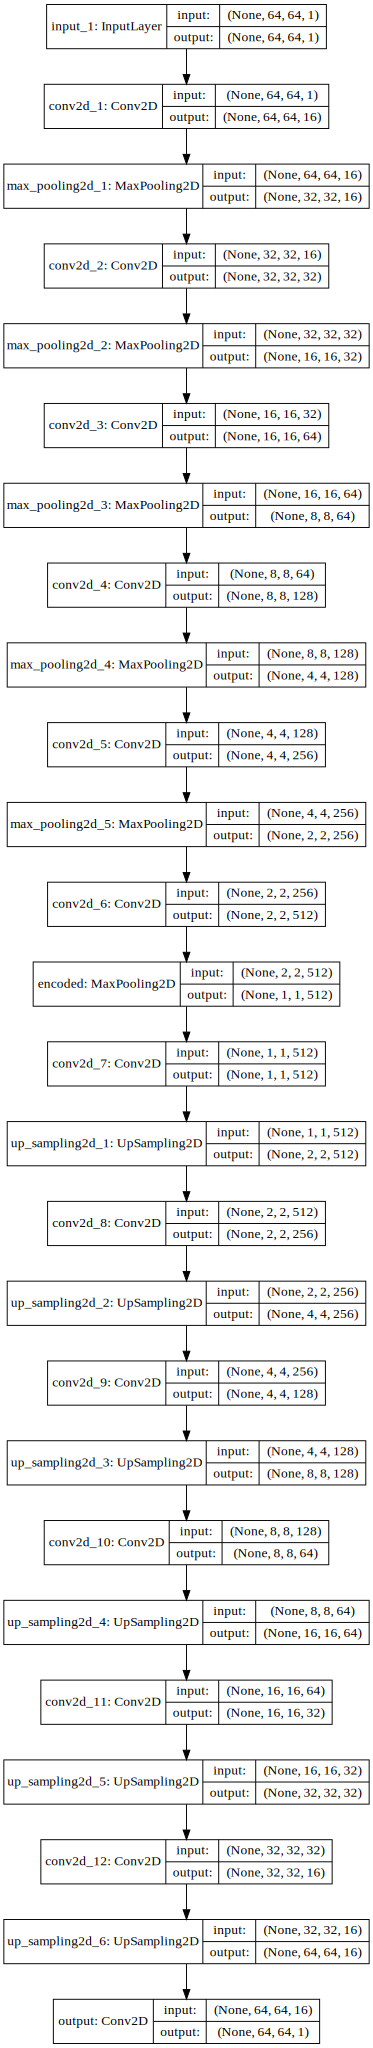

In [14]:

SVG(model_to_dot(autoencoder, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [75]:

def datagen(batch_size,list_of_writers, hshift = (-64,64) ,vis=False):
    counter = 0
    
    
    while True:
        counter = 0
        # for writer in unique_writers:
        #     print(identitycounter*100/stop_at, end='\r')
        w_ids,ids = [],[]
        writer_indexes = np.random.randint(0,len(list_of_writers),batch_size)
        x,y,writers = [],[],[]
        for writer_index in writer_indexes:
#             class_vectors = []
            writer = list_of_writers[writer_index]
#             print(writer)
            writer_samples = list(images[images['image'].str.match(writer)]['image'])
#             print('writer:',writer,', writer_samples:',writer_samples)
            if len(writer_samples) == 0:
                continue
            writer_sample_index = np.random.randint(0,len(writer_samples))

            #     unique_writers_count[writer] = len(writer_samples)
#             print('writer_sample_index:',writer_sample_index)
            csv_writer = writer_samples[writer_sample_index][:5]

    
            loaded_image = cv2.imread(os.path.join(image_path,writer_samples[writer_sample_index]),0)
            rand = np.random.randint(hshift[0],hshift[1])
            loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)
#             loaded_image = np.expand_dims(loaded_image,-1)
#             loaded_image_shifted = np.expand_dims(loaded_image_shifted,-1)
#             print('csv_writer:', csv_writer, ', writer:', writer)
#             display(csv_data[csv_data['ImageId'].str.match(csv_writer)])
#             csv_discreete_features = csv_data[csv_data['ImageId'].str.match(csv_writer)].iloc[0].values[2:]
#             print(csv_writer, writer_samples[writer_sample_index])
#             print(csv_writer,csv_discreete_features)
#             for i in range(1,9):
#                 print(csv_discreete_features[i-1],end=',')
#             f_1_out.append(csv_discreete_features[0])
#             f_2_out.append(csv_discreete_features[1])
#             f_3_out.append(csv_discreete_features[2])
#             f_4_out.append(csv_discreete_features[3])
#             f_5_out.append(csv_discreete_features[4])
#             f_6_out.append(csv_discreete_features[5])
#             f_7_out.append(csv_discreete_features[6])
#             f_8_out.append(csv_discreete_features[7])
#                 class_vectors.append(to_categorical(csv_discreete_features[i-1],num_classes=feature_lengths['f'+str(i)]))
#             print("\n",len(class_vectors))
#             print('\n-----------')
            
#             print("++++++++++++++++++++++[",counter,"]+++++++++++++++++++++++")
        #     imgcounter = 0
        #     for sample in writer_samples:
        #         imagepath = os.path.join(image_path,sample)
        #         raw_img = cv2.imread(imagepath)
        #         imgcounter+=1
        #     imgcounter=0
        #     identitycounter += 1
            x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
            y.append(255.0-loaded_image.reshape((64,64,1)))
            w_ids.append(writer[:4])
            writers.append(writer_samples[writer_sample_index])
            ids.append(writer_index)
            
            counter+=1
#             print('counter:', counter, end='\r')
        if counter <= batch_size:
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(ids),np.array(writers)]
            else:
                yield np.array(x)/255.0,np.array(y)/255.0
                    

In [76]:
# # unique_writers_count
# f_count = {}
train_list_of_writers = train_csv_data['ImageId'].unique()
val_list_of_writers = val_csv_data['ImageId'].unique()
batch_size = 64

tg = datagen(batch_size,train_list_of_writers, hshift = (-64,64))
vg = datagen(batch_size,val_list_of_writers, hshift = (-64,64))
test_g = datagen(4,val_list_of_writers, hshift = (-12,12))

In [78]:
# images
for i in range(10):
    inputs,y = next(tg)
inputs.shape , y.shape#, o[0].shape #, o[1].shape,o[2].shape,o[3].shape,o[4].shape,o[5].shape,o[6].shape,o[7].shape

((64, 64, 64, 1), (64, 64, 64, 1))

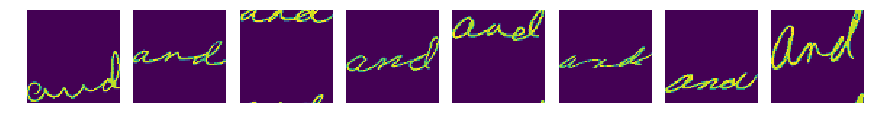

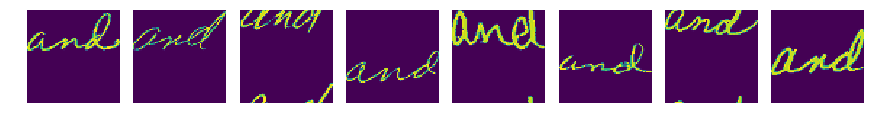

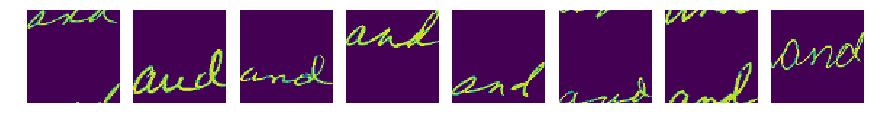

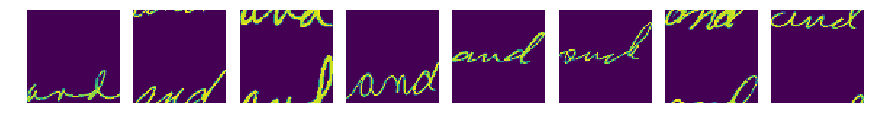

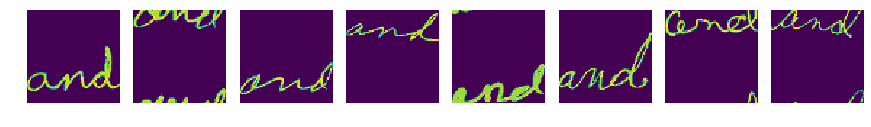

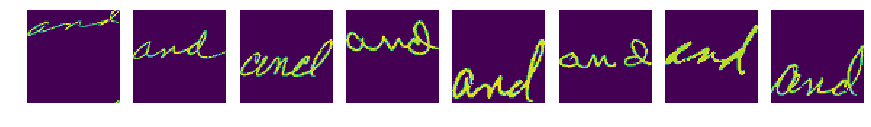

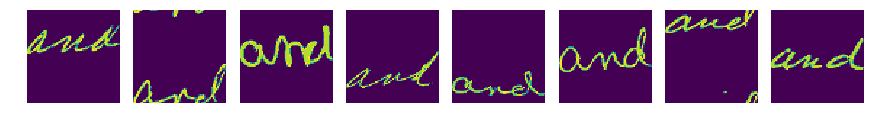

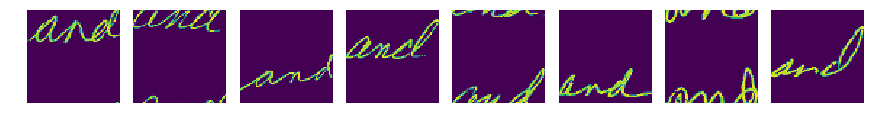

In [18]:
for r in range(8):
    f,ax = plt.subplots(1,8)
    f.subplots_adjust(hspace = .00, wspace=.15)
    f.set_size_inches(15,5)
    for c in range (8):
        ax[c].imshow(inputs[c+r*8].reshape((64,64)))
        ax[c].axis('off')

In [19]:
mc = ModelCheckpoint(filepath='simple_ae_maxpool_less_weights_v3.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')
autoencoder.load_weights('simple_ae_maxpool_less_weights_v3.h5')

In [20]:
# EPOCHS = 50000

# hist = autoencoder.fit_generator(tg, callbacks=[mc,es]
#                                     , epochs=EPOCHS
#                                     , steps_per_epoch = 1
#                                     , validation_data = vg
#                                     , validation_steps = 1
#                                     , verbose = 3
                                    
#                                    )

In [21]:
# df_hist = pd.DataFrame(hist.history)
# df_hist.plot(subplots=True, figsize=(15,15))
# print(df_hist['val_loss'].min())
# df_hist[df_hist['val_loss']<=0.1054]

In [22]:
# human_features.load_weights('human_features_weights_v2.h5')

In [23]:
# # print(df_hist.columns)
# print(df_hist['val_out_feature_1_acc'].max(), df_hist['val_out_feature_2_acc'].max(),
#        df_hist['val_out_feature_3_acc'].max(), df_hist['val_out_feature_4_acc'].max(),
#        df_hist['val_out_feature_5_acc'].max(), df_hist['val_out_feature_6_acc'].max(),
#        df_hist['val_out_feature_7_acc'].max(), df_hist['val_out_feature_8_acc'].max())
# # df_hist[df_hist['val_acc']>10.2]

In [65]:
test_g = datagen(len(val_list_of_writers)*5,val_list_of_writers, hshift = (-12,12), vis=True)
vx,vy = next(test_g)

(1621, 64, 64, 1) (1621,)


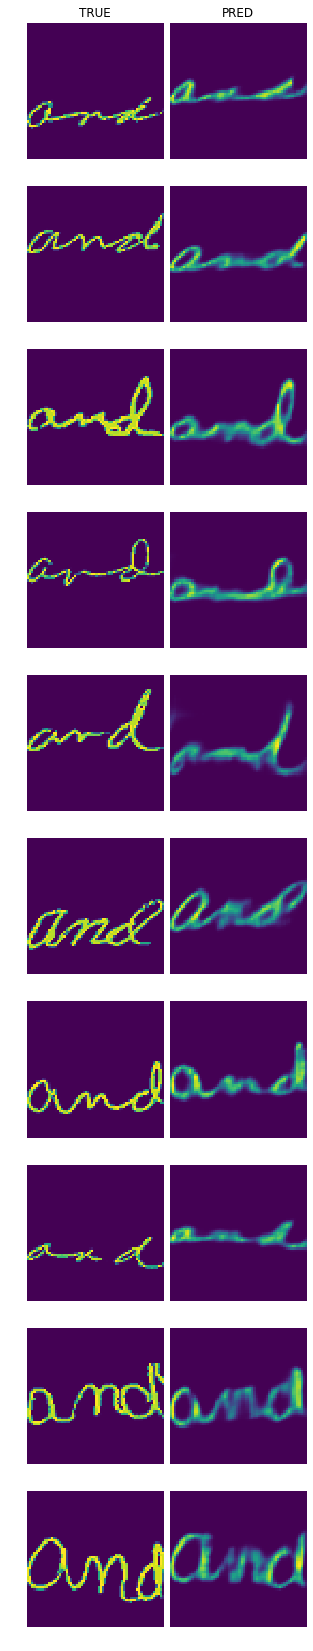

In [81]:

print(vx.shape,vy[0].shape)
py = autoencoder.predict(vx[:10])
f,ax = plt.subplots(len(vx[:10]),2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,len(vx[:10])*3)
ax[0,0].set_title('TRUE')
ax[0,1].set_title('PRED')
for i in range(len(vx[:10])):
#     print(vy[0][i], vy[1][i])
    ax[i,0].imshow(vx[i].reshape((64,64)))
    ax[i,0].axis('off')
    
    ax[i,1].imshow(py[i].reshape((64,64)))
    ax[i,1].axis('off')


In [67]:
encoder = Model(inputs=autoencoder.inputs,outputs=autoencoder.get_layer('encoded').output)


In [68]:
# df_val = pd.DataFrame(vy).T
# df_val.columns = ['identity','id','imagename']
# df_val = df_val.sort_values(by=['identity','imagename'])
# df_val = df_val.drop_duplicates()
# df_val = df_val.drop(columns=['id'])
# df_val

In [82]:
ids = vy[0].reshape(-1,1)
imagenames = vy[2].reshape(-1,1)
preds = encoder.predict(vx).reshape((-1,512))
# print(ids.shape,preds.shape)
# 
data=[]
for i in range(len(vx)):
    data.append([ids[i][0],imagenames[i][0],preds[i]])
df_data = pd.DataFrame(data=data, columns=['identity','imagename','latent'])
# df_outs['ids'] = ids
# df_outs['preds'] = preds 
df_data=df_data.sort_values(by='identity').reset_index()
df_data.shape

(1621, 4)

In [83]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook

In [84]:
cos_dist_out = cosine_similarity(list(df_data['latent'].values))

In [112]:
queried_count, idx_count, tp, tn, fp, fn = 0,0,0,0,0,0
cos_thresh = 0.6
data_result = []
fp_list = []
fn_list = []
r_counter = 0
stop_at = 10
prev_query = ''
prev_given = ''
given_count = 0
for row in tqdm_notebook(cos_dist_out):
    c_counter = 0
    given_idx = df_data.iloc[r_counter]['identity']
    given_img = df_data.iloc[r_counter]['imagename']
    for col in row:
        queried_idx = df_data.iloc[c_counter]['identity']
        queried_img = df_data.iloc[c_counter]['imagename']
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            tp += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            tn += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            fp += 1
            fp_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            fn += 1
            fn_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx):
            idx_count += 1
#             print('--i--',idx_count,'--i--')
#             print(given_idx,queried_idx)
        if prev_query != queried_idx:
#             print('--q--',queried_count,'--q--')
            queried_count += 1
        c_counter += 1
        prev_query = queried_idx
#         if queried_count == stop_at:
#             break
    precision = tp/(fp+tp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    total = np.sum((tp,tn,fp,fn))
    accuracy = (tp+tn)/total
    data_result.append([given_idx,given_img, idx_count, tp, tn, fp, fn,precision,recall,f1,accuracy, total, fp_list, fn_list])
    if prev_given != given_idx:
#         print('----',given_count,'-----')
        given_count+=1
    r_counter += 1
    prev_given = given_idx
    queried_count, idx_count, tp, tn, fp, fn = 0, 0, 0, 0, 0, 0
    fp_list = []
    fn_list = []
#     if given_count == stop_at:
#         break

In [113]:
df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
df_cos_dist_out=df_cos_dist_out.sort_values(by='identity').reset_index().drop(columns=['index'])
df_cos_dist_out.head(50)

,identity,imagename,total_images_identity,TP,TN,FP,FN,precision,recall,f1,accuracy,total_images,FP_List,FN_List
0,0301,0301c_num1.png,3,2,1574,44,1,0.043478,0.666667,0.081633,0.972239,1621,"[0302/0302b_num1.png, 0302/0302b_num1.png, 030...",[0301/0301c_num2.png]
1,0301,0301c_num2.png,3,1,1594,24,2,0.040000,0.333333,0.071429,0.983961,1621,"[0351/0351b_num2.png, 0351/0351b_num2.png, 041...","[0301/0301c_num1.png, 0301/0301c_num1.png]"
2,0301,0301c_num1.png,3,2,1574,44,1,0.043478,0.666667,0.081633,0.972239,1621,"[0302/0302b_num1.png, 0302/0302b_num1.png, 030...",[0301/0301c_num2.png]
3,0302,0302a_num3.png,13,12,1482,126,1,0.086957,0.923077,0.158940,0.921653,1621,"[0330/0330a_num2.png, 0333/0333c_num1.png, 033...",[0302/0302a_num5.png]
4,0302,0302c_num1.png,13,12,1471,137,1,0.080537,0.923077,0.148148,0.914867,1621,"[0333/0333c_num1.png, 0337/0337b_num4.png, 034...",[0302/0302a_num5.png]
5,0302,0302c_num1.png,13,12,1477,131,1,0.083916,0.923077,0.153846,0.918569,1621,"[0333/0333c_num1.png, 0337/0337b_num4.png, 034...",[0302/0302a_num5.png]
6,0302,0302c_num1.png,13,12,1454,154,1,0.072289,0.923077,0.134078,0.904380,1621,"[0333/0333c_num1.png, 0337/0337b_num4.png, 034...",[0302/0302a_num5.png]
7,0302,0302b_num1.png,13,11,1479,129,2,0.078571,0.846154,0.143791,0.919186,1621,"[0301/0301c_num1.png, 0301/0301c_num1.png, 031...","[0302/0302a_num1.png, 0302/0302a_num5.png]"
8,0302,0302a_num1.png,13,12,1469,139,1,0.079470,0.923077,0.146341,0.913634,1621,"[0317/0317a_num4.png, 0330/0330a_num2.png, 034...",[0302/0302b_num1.png]
9,0302,0302a_num5.png,13,2,1522,86,11,0.022727,0.153846,0.039604,0.940160,1621,"[0375/0375c_num1.png, 0375/0375c_num1.png, 038...","[0302/0302c_num1.png, 0302/0302c_num1.png, 030..."


In [125]:
from sklearn.metrics import confusion_matrix

cos_dist_out.shape

(1621, 1621)

In [123]:
# print(df_cos_dist_out.keys())
total = df_cos_dist_out.shape[0]
total_images_identity = df_cos_dist_out['total_images_identity']
tps = df_cos_dist_out['TP'].sum()
fps = df_cos_dist_out['FP'].sum()
tns = df_cos_dist_out['TN'].sum()
fns = df_cos_dist_out['FN'].sum()
precision = tps/(fps+tps)
recall = tps/(tps+fns)
f1 = 2*(precision*recall)/(precision+recall)
print('precision:',precision,'\nrecall:',recall,'\nf1:',f1)
acc = df_cos_dist_out['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(df_cos_dist_out['TP']/total_images_identity))
print('Inter Writer Accuracy (Type 2)::',tns/total/total)
print('acc:',acc)

precision: 0.11014626635873749 
recall: 0.6666459588743244 
f1: 0.18905586582336462
Intra Writer Accuracy (Type 1): 0.7091903806467209
Inter Writer Accuracy (Type 2):: 0.9608808813684975
acc: 0.9649647725849918


Text(0.5, 1.0, 'Right Input')

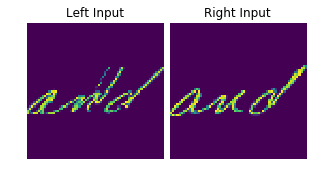

In [89]:
# test_im_shifted=test_im_normal
# test_im_shifted = vx[-2]
# rand = np.random.randint(-12,12)
# test_im_shifted=np.roll(axis=0,a=test_im_shifted,shift=-10)
# test = np.zeros((64,64,1))
# test[0:45]=test_im_shifted
# test_im_normal = vx[1]
# test_im_shifted = vx[2]
# plt.imshow(test_im_shifted.reshape((64,64)))
test_im_normal = 255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/0301c_num2.png',0)
test_im_shifted = 255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/0301c_num1.png',0)
f,ax = plt.subplots(1,2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,1*3)
ax[0].imshow(test_im_normal.reshape((64,64)))
ax[0].axis('off')

ax[1].imshow(test_im_shifted.reshape((64,64)))
ax[1].axis('off')
ax[0].set_title('Left Input')
ax[1].set_title('Right Input')

In [48]:
py1 = encoder.predict(test_im_normal.reshape((1,64,64,1)))
py2 = encoder.predict(test_im_shifted.reshape((1,64,64,1)))
py1[py1==0].shape,py2[py2==0].shape

((310,), (270,))

In [49]:
py1 = py1.reshape((-1,512))
py2 = py2.reshape((-1,512))
print(py1.shape,py2.shape)
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
cosine_similarity(py1,py2), cosine_distances(py1,py2), euclidean_distances(py1,py2)

(1, 512) (1, 512)


(array([[0.09495182]], dtype=float32),
 array([[0.9050482]], dtype=float32),
 array([[31.975447]], dtype=float32))

In [230]:
val_list_of_writers[:2]

array(['0344c', '0564a'], dtype=object)